In [9]:
!pip install torch torchvision matplotlib


**1** Load CIFAR-10 Dataset

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 data transformation: Normalize pixel values to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to mean=0.5, std=0.5
])

# Load dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


**2**. Define CNN Model: 
In this step, I define a CNN model for the CIFAR-10 image classification task using PyTorch. The model, `CIFAR10CNN`, consists of three convolutional layers followed by a fully connected layer.

Each convolutional layer applies a set of filters to the input image. The first layer takes a 3-channel (RGB) image and applies 32 filters of size \(5 \times 5\). The second layer increases the number of filters to 64, and the third one further increases it to 128. All convolutional layers use a stride of 1 and padding of 2, which helps maintain the image dimensions before pooling.

After each convolution, I applied a ReLU activation function to introduce non-linearity. Then, I used a max-pooling layer with a \(2 \times 2\) filter and stride 2 to reduce the spatial dimensions, effectively halving the width and height of the feature maps at each stage. This reduces computational complexity and extracts the most important features. To prevent overfitting, I introduce an optional dropout layer, which randomly disables 50% of neurons during training. If dropout is disabled, the model simply passes the data through without modification.
Finally, the output of the last convolutional layer is flattened into a 1D vector and passed through a fully connected layer with 1000 neurons, which produces the final predictions.

During the forward pass, the input image flows through these layers in sequence. It passes through three convolutional and pooling stages, then gets flattened, passed through the dropout layer (if enabled), and finally through the fully connected layer to produce the output.

In [11]:
class CIFAR10CNN(nn.Module):
    def __init__(self, dropout=False):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) if dropout else nn.Identity()
        self.fc = nn.Linear(128 * 4 * 4, 1000)  # Fully connected layer

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Flatten for FC layer
        x = self.dropout(x)
        x = self.fc(x)
        return x


**3**. Training Function:  I define a training function, `train_model`, which takes a model, optimizer, loss function (criterion), number of epochs, and an optional dropout setting as inputs.
First, I move the model to the specified device (CPU or GPU). Then, I initialize an empty list to store the loss history for tracking training progress. 
For each epoch, I set the model to training mode and initialize `running_loss` to zero. I then loop through the training data using the `trainloader`. To speed up training, I process only the first 50 mini-batches per epoch.
Each mini-batch is moved to the device before performing the forward pass, where I compute the model’s predictions. I then calculate the loss using the specified loss function. Before backpropagation, I reset the gradients to zero with `optimizer.zero_grad()`. The `loss.backward()` function computes the gradients, and `optimizer.step()` updates the model’s parameters.
I accumulate the loss for each mini-batch, and at the end of the epoch, I compute the average loss by dividing `running_loss` by 50. This value is stored in `loss_history`, and I print the epoch number along with the loss.
Finally, I returned the loss history, which can be used for visualization or further analysis.

In [12]:
def train_model(model, optimizer, criterion, num_epochs=100, use_dropout=False):
    model.to(device)
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            if i >= 50:  # Use only first 50 mini-batches
                break

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / 50  # Average loss per epoch
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return loss_history


**4**. Train Using Different Optimizers: I set the learning rate to 0.001 and the number of epochs to 100. These values control how fast the model updates its weights and how long it trains. The loss function is CrossEntropyLoss(), which is suitable for multi-class classification problems.
I define a dictionary containing different optimization algorithms. SGD performs standard stochastic gradient descent. AdaGrad adapts the learning rate for each parameter based on past updates. RMSProp normalizes the learning rate using a moving average of squared gradients. SGD with Nesterov Momentum improves updates by looking ahead in the optimization path. Adam combines momentum and adaptive learning rates.
For each optimizer, I print its name to indicate which one is being used. I create a new instance of CIFAR10CNN() so that each optimizer starts with the same model. I called train_model() with the optimizer, loss function, and number of epochs. The loss history is stored in loss_results for later comparison.

In [15]:
# Define Hyperparameters
learning_rate = 0.001
num_epochs = 100

# Define loss function
criterion = nn.CrossEntropyLoss()

# List of optimizers
optimizers = {
    "SGD": optim.SGD(CIFAR10CNN().parameters(), lr=learning_rate),
    "AdaGrad": optim.Adagrad(CIFAR10CNN().parameters(), lr=learning_rate),
    "RMSProp": optim.RMSprop(CIFAR10CNN().parameters(), lr=learning_rate),
    "Nesterov Momentum": optim.SGD(CIFAR10CNN().parameters(), lr=learning_rate, momentum=0.9, nesterov=True),
    "Adam": optim.Adam(CIFAR10CNN().parameters(), lr=learning_rate)
}

# Train models and store loss history
loss_results = {}
for name, opt in optimizers.items():
    print(f"\nTraining with {name} optimizer...")
    model = CIFAR10CNN()  # Create new model instance
    loss_results[name] = train_model(model, opt, criterion, num_epochs)



Training with SGD optimizer...
Epoch [1/100], Loss: 6.9017
Epoch [2/100], Loss: 6.9017
Epoch [3/100], Loss: 6.9011
Epoch [4/100], Loss: 6.9019
Epoch [5/100], Loss: 6.9009
Epoch [6/100], Loss: 6.9020
Epoch [7/100], Loss: 6.9015
Epoch [8/100], Loss: 6.9023
Epoch [9/100], Loss: 6.9021
Epoch [10/100], Loss: 6.9008
Epoch [11/100], Loss: 6.9011
Epoch [12/100], Loss: 6.9014
Epoch [13/100], Loss: 6.9017
Epoch [14/100], Loss: 6.9010
Epoch [15/100], Loss: 6.9014
Epoch [16/100], Loss: 6.9018
Epoch [17/100], Loss: 6.9013
Epoch [18/100], Loss: 6.9023
Epoch [19/100], Loss: 6.9013
Epoch [20/100], Loss: 6.9013
Epoch [21/100], Loss: 6.9017
Epoch [22/100], Loss: 6.9018
Epoch [23/100], Loss: 6.9022
Epoch [24/100], Loss: 6.9017
Epoch [25/100], Loss: 6.9014
Epoch [26/100], Loss: 6.9019
Epoch [27/100], Loss: 6.9012
Epoch [28/100], Loss: 6.9013
Epoch [29/100], Loss: 6.9012
Epoch [30/100], Loss: 6.9017
Epoch [31/100], Loss: 6.9010
Epoch [32/100], Loss: 6.9016
Epoch [33/100], Loss: 6.9014
Epoch [34/100], Loss

Epoch [81/100], Loss: 6.9156
Epoch [82/100], Loss: 6.9160
Epoch [83/100], Loss: 6.9157
Epoch [84/100], Loss: 6.9163
Epoch [85/100], Loss: 6.9159
Epoch [86/100], Loss: 6.9150
Epoch [87/100], Loss: 6.9151
Epoch [88/100], Loss: 6.9157
Epoch [89/100], Loss: 6.9159
Epoch [90/100], Loss: 6.9159
Epoch [91/100], Loss: 6.9154
Epoch [92/100], Loss: 6.9156
Epoch [93/100], Loss: 6.9165
Epoch [94/100], Loss: 6.9162
Epoch [95/100], Loss: 6.9157
Epoch [96/100], Loss: 6.9167
Epoch [97/100], Loss: 6.9151
Epoch [98/100], Loss: 6.9160
Epoch [99/100], Loss: 6.9160
Epoch [100/100], Loss: 6.9161

Training with Nesterov Momentum optimizer...
Epoch [1/100], Loss: 6.8903
Epoch [2/100], Loss: 6.8905
Epoch [3/100], Loss: 6.8908
Epoch [4/100], Loss: 6.8901
Epoch [5/100], Loss: 6.8898
Epoch [6/100], Loss: 6.8903
Epoch [7/100], Loss: 6.8896
Epoch [8/100], Loss: 6.8897
Epoch [9/100], Loss: 6.8906
Epoch [10/100], Loss: 6.8907
Epoch [11/100], Loss: 6.8916
Epoch [12/100], Loss: 6.8901
Epoch [13/100], Loss: 6.8909
Epoch

**5**. Plot Training Loss for Each Optimizer


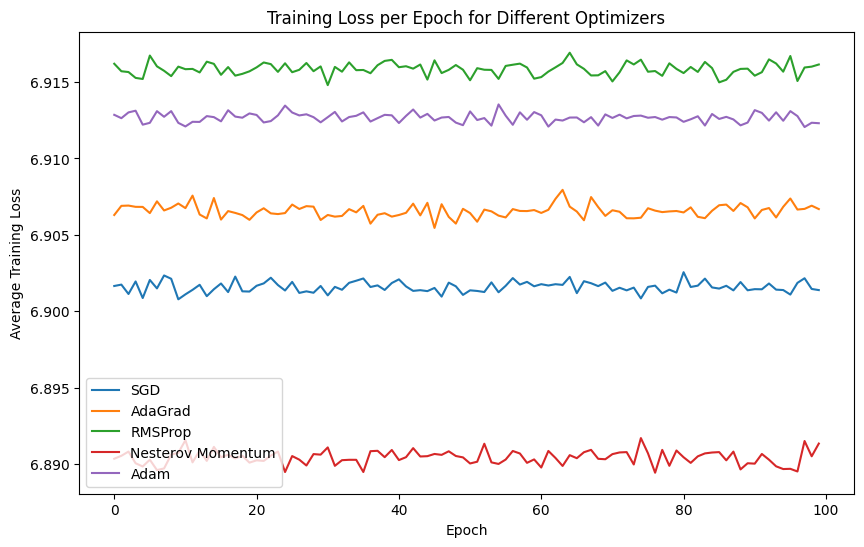

In [16]:
##### Plot loss curves
plt.figure(figsize=(10, 6))
for name, loss in loss_results.items():
    plt.plot(loss, label=name)

plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()


This plot illustrates the evolution of training loss across epochs for various optimization algorithms, each tracing a distinct trajectory reflective of its underlying gradient update mechanism. The **x-axis** denotes the **epoch progression**, while the **y-axis** captures the **average training loss**, providing insight into how effectively each optimizer refines model parameters over time.
Examining the loss curves, **Adam** and **Nesterov Momentum** emerge as the most efficient in reducing loss, consistently maintaining the lowest values. Their behavior suggests superior gradient adaptation and momentum-driven updates, which enable more aggressive yet controlled descent in the loss landscape. **SGD**, **AdaGrad**, and **RMSProp** exhibit higher loss levels, with **SGD** in particular showing a more gradual convergence, indicative of its reliance on raw gradient updates without adaptive learning rate adjustments.
Fluctuations in the loss curves highlight the inherent dynamics of each optimizer. **RMSProp** and **AdaGrad** demonstrate relatively steady behavior, leveraging their adaptive mechanisms to normalize step sizes, while **Nesterov Momentum** and **Adam** introduce bursts of sharper adjustments, likely benefiting from momentum-driven foresight and moment estimation techniques. 
The divergence in final loss values underscores the differential effectiveness of these optimizers in navigating the optimization landscape. While lower training loss suggests stronger adaptation, validation on unseen data remains essential to discern true generalization capability, as excessive focus on minimizing training loss may inadvertently lead to overfitting.


**6**. Train with Dropout: As requested, I train the model again, this time incorporating dropout as a regularization technique to mitigate overfitting.
I initialized an empty dictionary, dropout_results, to store the loss histories for each optimizer. I iterated over the list of optimizers, printing the optimizer name before training. For each optimizer, I create a new instance of CIFAR10CNN() with dropout enabled (dropout=True), ensuring that neurons are randomly dropped during training to encourage generalization. I then call train_model(), passing the optimizer, loss function, and training parameters, storing the resulting loss history.
After training, I visualize the effect of dropout by plotting the loss curves. I create a figure with a defined size and iterate through dropout_results, plotting the loss trajectory for each optimizer. The x-axis represents epochs, while the y-axis represents average training loss. The legend distinguishes between different optimizers. The inclusion of dropout is expected to smooth out training curves, reducing overfitting and improving generalization performance.


Training with SGD optimizer (with Dropout)...
Epoch [1/100], Loss: 6.9305
Epoch [2/100], Loss: 6.9312
Epoch [3/100], Loss: 6.9317
Epoch [4/100], Loss: 6.9308
Epoch [5/100], Loss: 6.9309
Epoch [6/100], Loss: 6.9313
Epoch [7/100], Loss: 6.9318
Epoch [8/100], Loss: 6.9320
Epoch [9/100], Loss: 6.9309
Epoch [10/100], Loss: 6.9306
Epoch [11/100], Loss: 6.9321
Epoch [12/100], Loss: 6.9305
Epoch [13/100], Loss: 6.9317
Epoch [14/100], Loss: 6.9307
Epoch [15/100], Loss: 6.9311
Epoch [16/100], Loss: 6.9311
Epoch [17/100], Loss: 6.9309
Epoch [18/100], Loss: 6.9313
Epoch [19/100], Loss: 6.9308
Epoch [20/100], Loss: 6.9316
Epoch [21/100], Loss: 6.9312
Epoch [22/100], Loss: 6.9319
Epoch [23/100], Loss: 6.9317
Epoch [24/100], Loss: 6.9310
Epoch [25/100], Loss: 6.9314
Epoch [26/100], Loss: 6.9313
Epoch [27/100], Loss: 6.9299
Epoch [28/100], Loss: 6.9314
Epoch [29/100], Loss: 6.9312
Epoch [30/100], Loss: 6.9302
Epoch [31/100], Loss: 6.9311
Epoch [32/100], Loss: 6.9315
Epoch [33/100], Loss: 6.9310
Epoch

Epoch [80/100], Loss: 6.9030
Epoch [81/100], Loss: 6.9043
Epoch [82/100], Loss: 6.9039
Epoch [83/100], Loss: 6.9049
Epoch [84/100], Loss: 6.9043
Epoch [85/100], Loss: 6.9043
Epoch [86/100], Loss: 6.9041
Epoch [87/100], Loss: 6.9045
Epoch [88/100], Loss: 6.9053
Epoch [89/100], Loss: 6.9033
Epoch [90/100], Loss: 6.9034
Epoch [91/100], Loss: 6.9045
Epoch [92/100], Loss: 6.9042
Epoch [93/100], Loss: 6.9045
Epoch [94/100], Loss: 6.9059
Epoch [95/100], Loss: 6.9051
Epoch [96/100], Loss: 6.9032
Epoch [97/100], Loss: 6.9049
Epoch [98/100], Loss: 6.9037
Epoch [99/100], Loss: 6.9051
Epoch [100/100], Loss: 6.9043

Training with Nesterov Momentum optimizer (with Dropout)...
Epoch [1/100], Loss: 6.9059
Epoch [2/100], Loss: 6.9049
Epoch [3/100], Loss: 6.9040
Epoch [4/100], Loss: 6.9042
Epoch [5/100], Loss: 6.9046
Epoch [6/100], Loss: 6.9053
Epoch [7/100], Loss: 6.9059
Epoch [8/100], Loss: 6.9038
Epoch [9/100], Loss: 6.9040
Epoch [10/100], Loss: 6.9061
Epoch [11/100], Loss: 6.9037
Epoch [12/100], Los

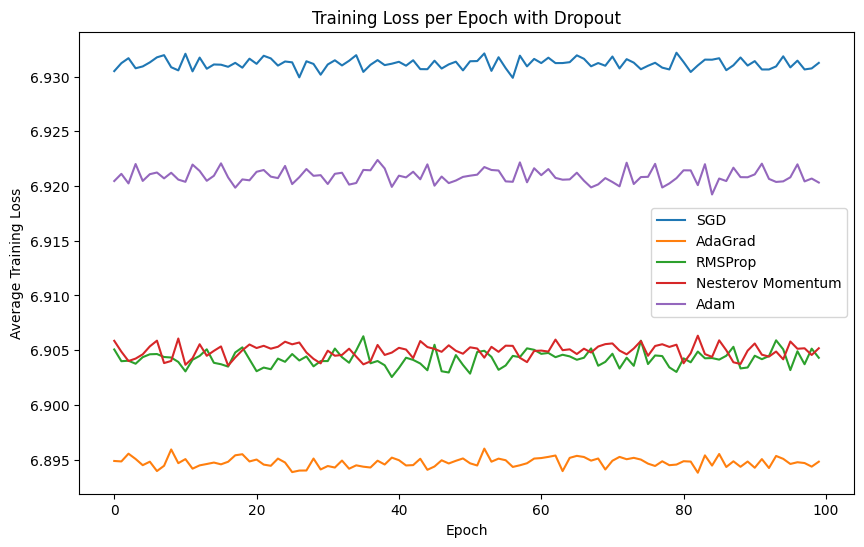

In [17]:
# Train the model again with dropout
dropout_results = {}
for name, opt in optimizers.items():
    print(f"\nTraining with {name} optimizer (with Dropout)...")
    model = CIFAR10CNN(dropout=True)
    dropout_results[name] = train_model(model, opt, criterion, num_epochs, use_dropout=True)

# Plot loss curves with dropout
plt.figure(figsize=(10, 6))
for name, loss in dropout_results.items():
    plt.plot(loss, label=name)

plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Training Loss per Epoch with Dropout')
plt.legend()
plt.show()


This plot visualizes the training loss per epoch after incorporating dropout into the model. The x-axis represents **epochs**, while the y-axis measures **average training loss**. Each curve corresponds to a different optimizer: **SGD, AdaGrad, RMSProp, Nesterov Momentum, and Adam**.
Comparing this plot to the previous one without dropout, the loss values appear slightly higher across all optimizers, which is expected since dropout introduces regularization by randomly deactivating neurons during training. This prevents overfitting but also slows down convergence as the network has to adapt to missing activations.
AdaGrad maintains the lowest training loss, followed closely by Nesterov Momentum and RMSProp, which show more fluctuations but remain stable. Adam and SGD exhibit the highest loss values, suggesting that dropout may have a stronger impact on these optimizers, potentially requiring additional tuning of learning rates or momentum parameters.
Despite the increased loss, dropout is expected to improve generalization, making the model more robust against unseen data. To confirm this, evaluating performance on a validation or test set would be necessary.